<a href="https://colab.research.google.com/github/ChengLiang-GitHub/mnist_practice/blob/main/0856814_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab1: How to Train a Classification Model
This tutorial is based on [PyTorch 1.2 Quickstart with Google Colab](https://colab.research.google.com/github/dair-ai/notebooks/blob/master/_notebooks/2020-03-18-pytorch_quick_start.ipynb).

In this tutorial, we will practice basic PyTorch usage and train a simple classification model.


# Steps Covered in this Tutorial
* Prepare environment, libraries and data
* Train on MNIST
* Test on MNIST
* Test on FashionMNIST with MNIST model
* Train on FashionMNIST
* Test on FashionMNIST


# Check GPU environment
We need to use GPU for training. First, go to the top left and select Runtime -> Change runtime type -> Make sure GPU is selected.

Additionally, you can check whether the GPU environment is indeed in use by running the ```!nvidia-smi``` command. If a table appears as a result, it signifies that it is utilizing the GPU environment.

In [ ]:
!nvidia-smi

Tue Nov 14 14:16:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    29W /  70W |   2783MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Libraries
Since we are using PyTorch, let's start by importing some libraries that we might use.

For more details on PyTorch libraries, you can refer to the [official PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## Import the Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), MNIST is a classic dataset of handwritten digit images, containing 60,000 training images and 10,000 testing images; it is like the "Hello World" dataset of machine learning.

We will utilize the built-in torchvision library in PyTorch to download and load the MNIST dataset. For other datasets provided by the torchvision library, you can refer to [this link](https://pytorch.org/vision/0.8/datasets.html).

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module.(Tensor is the fundamental data structure used to represent data in deep learning.)
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.
- The `num_workers` parameter is used to specify how many subprocesses are employed to load the data."

In [ ]:
BATCH_SIZE = 32

# transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Visualize Data
Displaying the data allows for the examination and observation of the type of data we have. Let's check what the dataset contains.

I will use matplotlib to print out some of the images from our dataset.

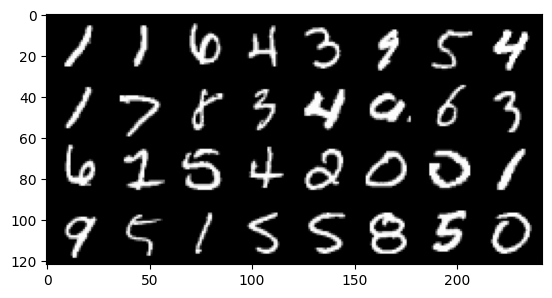

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def show_data(img):
    # Convert PyTorch Tensor to NumPy array and change the image dimensions from (C, H, W) to (H, W, C) to comply with the requirements of plt.imshow.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show_data(torchvision.utils.make_grid(images)) # make_grid combines a batch of images into a grid so that multiple images can be displayed at once.

Let's check the dimensions of a batch.

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


# The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model.

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).
- The (`24*24*64`) in the `nn.Linear` represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). The dimension of the output of the linear layer , `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`.

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)

        # 26x26x32 => 24x24x64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # Flatten and connect to FC, 24*24*64 is the size of the feature maps after the convolution
        self.fc1 = nn.Linear(24 * 24 * 64, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # 32x32x26x26 => 32x64x24x24
        x = self.conv2(x)
        x = F.relu(x)

        # flatten => 32 x (24*24*64)
        x = x.view(-1, 24 * 24 * 64)

        # logits => 32x10
        out = self.fc1(x)
        return out

As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [ ]:
# test the model with 1 batch
model = Model()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


# Train the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model.

We use CrossEntropyLoss as our loss function, which is suitable for handling classification problems, and Adam as the optimizer.

If you wish to try other combinations, you can refer to the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [optim](https://pytorch.org/docs/stable/optim.html) sections on the official PyTorch website.

In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# compute accuracy
def get_accuracy(predict, target, batch_size):
    corrects = (torch.max(predict, 1)[1].view(target.size()).data == target.data).sum()
    # Find the maximum value in the second dimension of 'predict', where [1] represents retrieving the predicted class index,
    # Reshaped it to match the shape of the 'target'.
    # Comparing with '==' results in a boolean array, where 1 represents a correct prediction and 0 represents an incorrect one.
    # Using 'sum' calculates the total number of correct predictions.

    accuracy = 100.0 * corrects/batch_size

    return accuracy.item()

Now it's time for training. This would take a while.

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model.train()

    # training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        # feed forward
        logits = model(images)
        predicts = F.softmax(logits, dim=1)
        # loss
        loss = criterion(predicts, labels)
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # update model parameters

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predicts, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch+1, train_running_loss / i, train_acc/i))

Epoch: 1 | Loss: 1.5298 | Train Accuracy: 93.39
Epoch: 2 | Loss: 1.4871 | Train Accuracy: 97.60
Epoch: 3 | Loss: 1.4811 | Train Accuracy: 98.16
Epoch: 4 | Loss: 1.4780 | Train Accuracy: 98.45
Epoch: 5 | Loss: 1.4761 | Train Accuracy: 98.65


# Testing on MNIST
We can compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)
    predicts = F.softmax(logits, dim=1)
    test_acc += get_accuracy(predicts, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 98.79


In [ ]:
# Visualize the predicted category for a randomly selected image.
def show_result(img, title, figsize=(2, 2)):  # The default size is 2x2 inches; you can adjust it as needed.
    plt.figure(figsize=figsize)
    npimg = img.numpy().squeeze()  # Remove the channel dimension
    plt.imshow(npimg, cmap='gray')  # Specify the colormap as 'gray'
    plt.title(title)
    plt.axis('off') # Hide the axes
    plt.show()

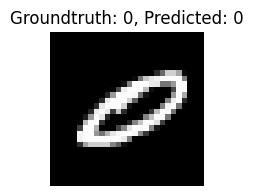

In [ ]:
import random

# Randomly select an index
random_index = random.randint(0, len(testset) - 1)

# Obtain the image and label of that index
image, label = testset[random_index]
image = image.unsqueeze(0).to(device)  # Add the batch dimension and move to the device

# Make predictions
logits = model(image)
predict = F.softmax(logits, dim=1)
_, predicted = torch.max(predict, 1)

# Display the image and the predicted result
show_result(image[0].cpu(), title=f"Groundtruth: {label}, Predicted: {predicted.item()}")

# Practice: Test on another dataset - FashionMNIST (30 points)
Now, we will apply the model we just trained directly to another dataset to see what effects will occur.

The dataset we are using is [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist), a dataset containing images of clothing in 10 different categories. Each category has 6,000 training images and 1,000 testing images, with each image sized at 28x28 pixels.

This dataset is used to evaluate the performance of machine learning models on image classification tasks, especially serving as a more challenging alternative to the traditional MNIST dataset.

# Import FashionMNIST Data
Just like before, we can directly use the built-in torchvision library in PyTorch to download and load the FashionMNIST dataset.

In [ ]:
# Please refer to the previous approach and use torchvision.datasets.FashionMNIST() to download and load the dataset.
# Declare F_trainset, F_trainloader, F_testset, and F_testloader
BATCH_SIZE = 512

# transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# download and load training dataset
F_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
F_trainloader = torch.utils.data.DataLoader(F_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
F_testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
F_testloader = torch.utils.data.DataLoader(F_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Before using the data, let’s visualize it first to take a look, as we did before.

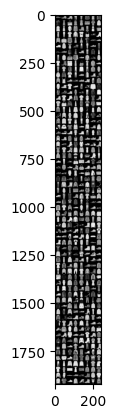

In [ ]:
# get a batch of training images
dataiter = iter(F_trainloader)
images, labels = next(dataiter)

# show images
show_data(torchvision.utils.make_grid(images))

# Testing on FashionMNIST with MNIST model
Please refer to the above practice and apply the model previously trained on MNIST to the testing of Fashion-MNIST data.

**You need to display the Test Accuracy. After completing the practice steps, the TA will check.**

In [ ]:
# Testing on FashionMNIST
test_acc = 0.0
for i, (images, labels) in enumerate(F_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)
    predicts = F.softmax(logits, dim=1)
    test_acc += get_accuracy(predicts, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 8.57


From this, we know that although both MNIST and FashionMNIST are datasets of 28x28 grayscale images, they have different contents and complexities.

MNIST mainly contains handwritten digits, while FashionMNIST contains images of clothing and accessories. Due to the significant feature differences between these two datasets, a model trained on one dataset cannot be directly applied to the other, at least not with the expectation of good performance.

# **Model after improving**

In [ ]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn2D_16 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2D_32 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2D_64 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, padding=0)

        self.pool = nn.MaxPool2d(2, 2)

        # Flatten and connect to FC, 24*24*64 is the size of the feature maps after the convolution
        self.fc1 = nn.Linear(28 * 28 * 64, 256)
        self.bn1D_256 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x28x28
        x = self.conv1(x)
        x = self.bn2D_16(x)
        x = F.relu(x)
        # x = self.bn2D_16(x)
        # 32x32x28x28 => 32x64x28x28
        x = self.conv2(x)
        x = self.bn2D_32(x)
        x = F.relu(x)
        # x = self.bn2D_32(x)
        # 32x64x28x28 => 32x64x14x14
        # x = self.pool(x)

        # 32x64x14x14 => 32x128x14x14
        x = self.conv3(x)
        x = self.bn2D_64(x)
        x = F.relu(x)
        # x = self.bn2D_64(x)
        # 32x128x14x14 => 32x256x14x14
        # x = self.conv4(x)
        # x = F.relu(x)
        # 32x256x14x14 => 32x256x7x7
        # x = self.pool(x)

        # flatten => 32 x (7*7*256)
        x = x.view(-1, 28 * 28 * 64)

        # logits => 32x10
        x = self.fc1(x)
        x = self.bn1D_256(x)
        out = self.fc2(x)
        return out

In [ ]:
# test the model with 1 batch
F_model = Model_2()
for images, labels in F_trainloader:
    print("batch size:", images.shape)
    out = F_model(images)
    print(out.shape)
    break

batch size: torch.Size([512, 1, 28, 28])
torch.Size([512, 10])


# Re-train the model with FashionMNIST data
Next, please refer to the previous approach and retrain the model using Fashion-MNIST data.

In [ ]:
# Set learning_rate, num_epochs, initialize model, loss function, and optimizer.
learning_rate = 0.001
num_epochs = 15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
F_model = Model_2()
F_model = F_model.to(device)
F_criterion = nn.CrossEntropyLoss()
F_optimizer = torch.optim.Adam(F_model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
lossPerEpoch = {"epoch":[],"loss":[]}
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    F_model.train()

    # training step
    for i, (images, labels) in enumerate(F_trainloader):

        images = images.to(device)
        labels = labels.to(device)

        # feed forward
        logits = F_model(images)
        predicts = F.softmax(logits, dim=1)
        # loss
        loss = F_criterion(predicts, labels)
        # back propagation
        F_optimizer.zero_grad()
        loss.backward()
        F_optimizer.step()  # update model parameters

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predicts, labels, BATCH_SIZE)

    F_model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch+1, train_running_loss / i, train_acc/i))
    lossPerEpoch["epoch"].append(epoch+1)
    lossPerEpoch["loss"].append(train_running_loss / i)

Epoch: 1 | Loss: 1.6288 | Train Accuracy: 85.78
Epoch: 2 | Loss: 1.5687 | Train Accuracy: 91.18
Epoch: 3 | Loss: 1.5528 | Train Accuracy: 92.64
Epoch: 4 | Loss: 1.5419 | Train Accuracy: 93.65
Epoch: 5 | Loss: 1.5335 | Train Accuracy: 94.43
Epoch: 6 | Loss: 1.5283 | Train Accuracy: 94.95
Epoch: 7 | Loss: 1.5239 | Train Accuracy: 95.31
Epoch: 8 | Loss: 1.5177 | Train Accuracy: 95.99
Epoch: 9 | Loss: 1.5150 | Train Accuracy: 96.17
Epoch: 10 | Loss: 1.5124 | Train Accuracy: 96.45
Epoch: 11 | Loss: 1.5100 | Train Accuracy: 96.70
Epoch: 12 | Loss: 1.5086 | Train Accuracy: 96.85
Epoch: 13 | Loss: 1.5063 | Train Accuracy: 97.01
Epoch: 14 | Loss: 1.5037 | Train Accuracy: 97.28
Epoch: 15 | Loss: 1.5016 | Train Accuracy: 97.49


<class 'pandas.core.frame.DataFrame'>
    epoch      loss
0       1  1.628798
1       2  1.568733
2       3  1.552791
3       4  1.541907
4       5  1.533471
5       6  1.528254
6       7  1.523894
7       8  1.517701
8       9  1.514989
9      10  1.512424
10     11  1.509966
11     12  1.508557
12     13  1.506275
13     14  1.503708
14     15  1.501556


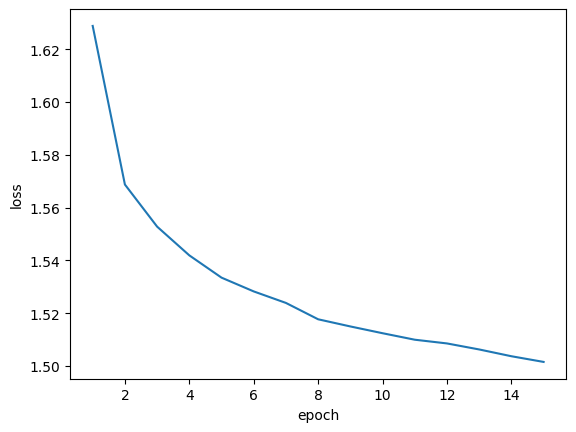

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# print(lossPerEpoch)
column_list = list(lossPerEpoch.keys())
df = pd.DataFrame(lossPerEpoch)
print(type(df[["epoch","loss"]]))
print(df)
sns.lineplot(data=df, x="epoch", y="loss")
plt.show()

# Testing on FashionMNIST
Test the model trained on FashionMNIST for test accuracy.

**You need to display the Test Accuracy. After completing the practice steps, the TA will check.**

In [ ]:
# Testing on FashionMNIST again using re-trained model
test_acc = 0.0
for i, (images, labels) in enumerate(F_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    logits = F_model(images)
    predicts = F.softmax(logits, dim=1)
    test_acc += get_accuracy(predicts, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 93.70


Show the prediction result for a randomly selected image.

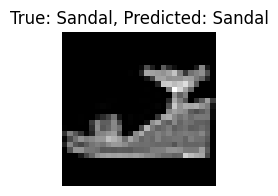

In [ ]:
random_index = random.randint(0, len(F_testset) - 1)

image, label = F_testset[random_index]
image = image.unsqueeze(0).to(device)

output = F_model(image)
_, predicted = torch.max(output, 1)

label_map = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
show_result(image[0].cpu(), title=f"True: {label_map[label]}, Predicted: {label_map[predicted.item()]}")

### **Lab DONE!! Please find the teaching assistant to check, and register your student ID.**
